# Skillenza - Devengers Hackthon Prediction

### Objective of the problem
The objective of the problem is to predict values “treatment” attribute from the given features of the test data. The predictions are to be written to a CSV file along with ID which is the unique identifier for each tuple. Please view the sample submission file to understand how the submission file is to be written. Please upload the submission file to get a score. 

### Description of files
**Training File** : All features including the target would be present in this file. Machine learning model would trained using this file. This file is to be used for training and validation.  
**Test File** : This file contains all features, but the target variable. Prediction is to be made for all tuples in the test file. The predicted values are to be written to a CSV file along with ID and uploaded.  
**Sample Submission** : Sample submission is an example of how the actual submission file should be like

### Features 
 - Timestamp  
 - Age  
 - Gender 
 - Country 
 - state: If you live in the United States, which state or territory do you live in? 
 - self_employed: Are you self-employed? 
 - family_history: Do you have a family history of mental illness? 
 - treatment: Does he or she really needs treatment. 
 - work_interfere: If you have a mental health condition, do you feel that it interferes with your work? 
 - no_employees: How many employees does your company or organization have? 
 - remote_work: Do you work remotely (outside of an office) at least 50% of the time? 
 - tech_company: Is your employer primarily a tech company/organization? 
 - benefits: Does your employer provide mental health benefits? 
 - care_options: Do you know the options for mental health care your employer provides? 
 - wellness_program: Has your employer ever discussed mental health as part of an employee wellness program? 
 - seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help? 
 - anonymity: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources? 
 - leave: How easy is it for you to take medical leave for a mental health condition? 
 - mental_health_consequence: Do you think that discussing a mental health issue with your employer would have negative consequences? 
 - phys_health_consequence: Do you think that discussing a physical health issue with your employer would have negative consequences? 
 - coworkers: Would you be willing to discuss a mental health issue with your coworkers? 
 - supervisor: Would you be willing to discuss a mental health issue with your direct supervisor(s)? 
 - mental_health_interview: Would you bring up a mental health issue with a potential employer in an interview? 
 - phys_health_interview: Would you bring up a physical health issue with a potential employer in an interview? 
 - mental_vs_physical: Do you feel that your employer takes mental health as seriously as physical health? 
 - obs_consequence: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace? 
 - comments: Any additional notes or comments.

In [1]:
import datetime
import glob
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import time
import xgboost as xgb

%matplotlib inline
%run ./plugins/widgets.py

Widget Loaded


### Global parameters and variables

In [2]:
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

## Load data

In [3]:
full_train_df = pd.read_csv('./data/devengers_train.csv')
print("Shape : ", full_train_df.shape)
full_train_df.sample(2)

Shape :  (1000, 28)


,s.no,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
750,751,2014-08-28 11:19:35,33,m,Norway,NaN,No,Yes,No,NaN,26-100,No,Yes,Yes,Yes,No,No,Don't know,Very easy,No,No,Some of them,Yes,No,No,Don't know,No,NaN
472,473,2014-08-27 16:13:42,29,Male,United States,OH,No,No,No,Sometimes,6-25,No,Yes,Don't know,No,No,No,Don't know,Very difficult,Yes,No,No,No,No,Maybe,No,No,NaN


In [4]:
full_test_df = pd.read_csv('./data/devengers_test.csv')
print("Shape : ", full_test_df.shape)
full_test_df.sample(2)

Shape :  (259, 27)


,s.no,Timestamp,Age,Gender,Country,state,self_employed,family_history,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
241,242,2015-04-11 14:35:22,31,Male,Poland,NaN,Yes,No,Often,6-25,Yes,Yes,No,No,No,No,Don't know,Somewhat easy,Maybe,No,Some of them,No,No,No,Don't know,No,NaN
200,201,2015-02-21 04:55:11,28,Male,Australia,NaN,No,No,Often,100-500,Yes,Yes,No,Yes,No,No,Don't know,Don't know,Yes,No,No,No,No,Maybe,No,No,NaN


## Data Pre-processing and Cleanup

In [5]:
def preprocess_and_cleanup(df, test_data=False):
    
    # Age Column Cleanup
    mean_age = np.mean(df['Age'][(df['Age']>=18) & (df['Age'] <= 100)].values)
    df['Age'] = np.where((df['Age'] >= 18) & (df['Age'] <= 100), df['Age'], mean_age)
    
    # Cleanup Gender Column
    df['Gender'] = df['Gender'].str.strip()
    male_strings = ['Male', 'male', 'M', 'm', 'Make', 'Man']
    df['gender_male'] = df['Gender'].isin(male_strings).astype(int)
    female_strings = ['Female', 'female', 'F', 'f', 'Woman']
    df['gender_female'] = df['Gender'].isin(female_strings).astype(int)
    df['gender_other'] = np.where((df['gender_male']==0) & (df['gender_female']==0), 1, 0)
    
    # Replace all no/dont know/yes with numeric values
    mcq_columns = ['self_employed', 'family_history', 'remote_work', 'tech_company', 'benefits', 
               'care_options', 'wellness_program', 'seek_help', 'anonymity', 'mental_health_consequence', 
               'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 
               'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
    if test_data==False:
        mcq_columns.append('treatment')
    for col in mcq_columns:
        df[col] = df[col].map({'Yes': 1, 
                               'Maybe': 0.5, 'Don\'t know': 0.5, 'Not sure': 0.5, 'Some of them' : 0.5,
                               'No': 0})

    # Convert Other Columns to Numeric
    df['work_interfere'] = df['work_interfere'].map({'Often': 1, 'Sometimes': 2/3, 'Rarely': 1/3, 'Never': 0})

    df['leave'] = df['leave'].map({'Very easy': 1, 'Somewhat easy': 3/4, 'Don\'t know ': 0.5, 
                                   'Somewhat difficult': 1/4, 'Very difficult': 0})

    # Drop Rubish Columns
    df = df.drop(['s.no', 'Timestamp', 'Gender', 'comments'], axis=1)
    
    # Final Step
    df = df.fillna(df.median())
    df = pd.get_dummies(df)
    df = df.reindex(columns=(sorted(df.columns)))
    
    return df

In [6]:
train_df = preprocess_and_cleanup(full_train_df, False)
train_df.sample(5)

,Age,Country_Australia,Country_Austria,"Country_Bahamas, The",Country_Belgium,Country_Bosnia and Herzegovina,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Colombia,Country_Costa Rica,Country_Croatia,Country_Denmark,Country_Finland,Country_France,Country_Germany,Country_Hungary,Country_India,Country_Ireland,Country_Israel,Country_Italy,Country_Japan,Country_Latvia,Country_Mexico,Country_Netherlands,Country_New Zealand,Country_Nigeria,Country_Norway,Country_Poland,Country_Portugal,Country_Romania,Country_Russia,Country_Singapore,Country_Slovenia,Country_South Africa,Country_Spain,Country_Sweden,Country_Switzerland,Country_Thailand,Country_United Kingdom,Country_United States,Country_Uruguay,Country_Zimbabwe,anonymity,benefits,care_options,coworkers,family_history,gender_female,gender_male,...,state_AL,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_NC,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,supervisor,tech_company,treatment,wellness_program,work_interfere
267,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.5,0.5,0.5,1.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,1.0,1.0,0.5,0.666667
751,42.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.5,0.5,0.5,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.666667
572,27.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.5,0.5,0.5,0.5,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.5,0.666667
843,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.5,0.5,0.5,0.5,0.0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.666667
353,26.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.5,1.0,0.5,0.5,1.0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,0.5,1.000000


In [7]:
test_df = preprocess_and_cleanup(full_test_df, True)
test_df.sample(5)

,Age,Country_Australia,Country_Belgium,Country_Brazil,Country_Bulgaria,Country_Canada,Country_China,Country_Colombia,Country_Croatia,Country_Czech Republic,Country_Finland,Country_France,Country_Georgia,Country_Germany,Country_Greece,Country_India,Country_Ireland,Country_Israel,Country_Italy,Country_Moldova,Country_Netherlands,Country_New Zealand,Country_Philippines,Country_Poland,Country_Singapore,Country_South Africa,Country_Sweden,Country_Switzerland,Country_United Kingdom,Country_United States,anonymity,benefits,care_options,coworkers,family_history,gender_female,gender_male,gender_other,leave,mental_health_consequence,mental_health_interview,mental_vs_physical,no_employees_1-5,no_employees_100-500,no_employees_26-100,no_employees_500-1000,no_employees_6-25,no_employees_More than 1000,obs_consequence,phys_health_consequence,phys_health_interview,remote_work,seek_help,self_employed,state_AL,state_CA,state_CT,state_FL,state_GA,state_IL,state_IN,state_MD,state_MI,state_MN,state_MO,state_NC,state_NJ,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,supervisor,tech_company,wellness_program,work_interfere
62,44.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.5,0.0,0.0,0.0,0,1,0,0.25,0.0,0.0,0.5,1,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.000000
58,31.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,1.0,0.5,0.5,1.0,0,1,0,0.75,0.5,0.0,0.5,0,0,0,0,0,1,0.0,0.0,0.5,0.0,0.5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.5,1.000000
34,36.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.5,0.5,0.0,0.0,0.0,0,1,0,0.75,1.0,0.0,0.5,0,1,0,0,0,0,1.0,0.5,0.5,0.0,0.5,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.000000
206,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.5,0.5,0.5,0.5,1.0,0,1,0,0.75,0.5,0.5,1.0,0,0,1,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,1.000000
174,20.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.0,0.0,0.5,0.0,0,1,0,0.00,1.0,0.0,0.0,0,0,1,0,0,0,0.0,1.0,0.5,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.333333


In [8]:
s1 = set(train_df.columns)
s2 = set(test_df.columns)
print("Missing from Test : ", s1 - s2)
print("\nMissing from Train : ", s2 - s1)

Missing from Test :  {'state_MS', 'state_RI', 'state_NE', 'Country_Japan', 'state_KY', 'Country_Mexico', 'Country_Zimbabwe', 'Country_Hungary', 'Country_Romania', 'state_AZ', 'Country_Nigeria', 'state_ME', 'state_WY', 'state_CO', 'Country_Costa Rica', 'Country_Bosnia and Herzegovina', 'state_NM', 'Country_Spain', 'Country_Denmark', 'Country_Austria', 'state_MA', 'state_IA', 'state_NV', 'Country_Uruguay', 'Country_Bahamas, The', 'Country_Latvia', 'Country_Russia', 'Country_Thailand', 'Country_Slovenia', 'state_LA', 'treatment', 'Country_Portugal', 'state_ID', 'state_DC', 'state_WV', 'state_KS', 'state_NH', 'Country_Norway'}

Missing from Train :  {'Country_China', 'Country_Philippines', 'Country_Georgia', 'Country_Moldova', 'Country_Czech Republic', 'Country_Greece'}


In [9]:
train_df, test_df = train_df.align(test_df, join='outer', axis=1, fill_value=0)

train_df = train_df.reindex(columns=(sorted(list([a for a in train_df.columns if a != 'treatment'])) + ['treatment']))
test_df = test_df.drop(['treatment'], axis=1)

## XGBoost

In [10]:
data_x, data_y = train_df.iloc[:,:-1], train_df.iloc[:,-1]
train_x, val_x, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2, random_state=64)

In [11]:
xgb_param = {
    'max_depth': 9, 
    'objective':'binary:logistic', 
    'n_estimators': 700,
    'learning_rate': 0.01,
    'tree_method':'gpu_hist'
}
xg_class = xgb.XGBClassifier(**xgb_param)

In [12]:
clock = time.time()
xg_class.fit(train_x, train_y)
clock = time.time() - clock
print("Time taken : {:.3f} sec".format(clock))

Time taken : 21.537 sec


In [13]:
y_pred = xg_class.predict_proba(val_x)
y_pred = y_pred[:,1]  # take the probability of True only

C:\Program Files\Python 3.6.3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


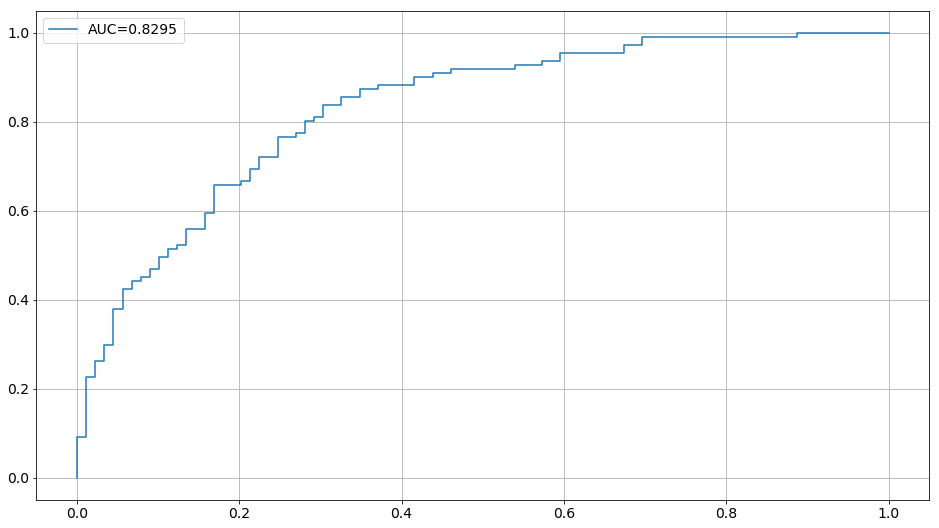

In [14]:
fpr, tpr, _ = metrics.roc_curve(val_y, y_pred)
auc = metrics.roc_auc_score(val_y, y_pred)
plt.plot(fpr, tpr, label="AUC={:.4f}".format(auc))
plt.legend()
plt.grid('on')
plt.show()

In [15]:
def model_report(pred_scores, test_y):
    metrics_df = pd.DataFrame()
    accuracy = []
    tp = []; fp = []; tn = []; fn = []
    f1_score = []
    precision = []
    recall = []
    thresholds = []
    for thres in log_progress(np.arange(0,1, 0.05)):
        pred_labels = [1 if x>thres else 0 for x in pred_scores]
        accuracy.append(metrics.accuracy_score(test_y,pred_labels))
        tn1, fp1, fn1, tp1 = metrics.confusion_matrix(test_y, pred_labels).ravel()
        tp.append(tp1);fp.append(fp1);tn.append(tn1);fn.append(fn1)
        precision.append(metrics.precision_score(test_y, pred_labels))
        recall.append(metrics.recall_score(test_y, pred_labels))
        f1_score.append(metrics.f1_score(test_y, pred_labels))
        thresholds.append(thres)
    metrics_df['thresholds'] = thresholds
    metrics_df['tp'] = tp
    metrics_df['fp'] = fp
    metrics_df['tn'] = tn
    metrics_df['fn'] = fn
    metrics_df['accuracy'] = accuracy
    metrics_df['f1_score'] = f1_score
    metrics_df['precision'] = precision
    metrics_df['recall'] = recall
    return metrics_df

model_report(y_pred, val_y)

,thresholds,tp,fp,tn,fn,accuracy,f1_score,precision,recall
0,0.00,111,89,0,0,0.555,0.713826,0.555000,1.000000
1,0.05,110,74,15,1,0.625,0.745763,0.597826,0.990991
2,0.10,106,58,31,5,0.685,0.770909,0.646341,0.954955
3,0.15,105,53,36,6,0.705,0.780669,0.664557,0.945946
4,0.20,102,46,43,9,0.725,0.787645,0.689189,0.918919
5,0.25,99,37,52,12,0.755,0.801619,0.727941,0.891892
6,0.30,97,31,58,14,0.775,0.811715,0.757812,0.873874
7,0.35,91,27,62,20,0.765,0.794760,0.771186,0.819820
8,0.40,89,25,64,22,0.765,0.791111,0.780702,0.801802
9,0.45,84,22,67,27,0.755,0.774194,0.792453,0.756757


## Cross Validation

In [16]:
param_dist = {
    'n_estimators': stats.randint(300, 1400),
    'learning_rate': stats.uniform(0.001, 0.1),
    'max_depth': [4, 5, 6, 7, 9, 11, 13, 15],
}
clf = RandomizedSearchCV(xg_class, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', 
                         error_score=0, verbose=2, n_jobs=8)

In [17]:
%time
_ = clf.fit(data_x, data_y)

Wall time: 0 ns
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  8.9min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 35.7min
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed: 55.4min finished


In [18]:
print(clf.best_score_)
print(clf.best_estimator_)

0.737
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.005741794950360157,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=1058, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, tree_method='gpu_hist')


## Test Data Predictions

In [19]:
clock = time.time()
clf.best_estimator_.fit(data_x, data_y)
clock = time.time() - clock
print("Time taken : {:.3f} sec".format(clock))

Time taken : 16.056 sec


In [20]:
train_y_pred = clf.best_estimator_.predict_proba(test_df)
train_y_pred = train_y_pred[:, 1]

In [22]:
sub_df = full_test_df[['s.no']].copy()
sub_df['treatment'] = np.where(train_y_pred < 0.45, 'No', 'Yes')
sub_df.head(5)

,s.no,treatment
0,1,Yes
1,2,Yes
2,3,Yes
3,4,Yes
4,5,Yes


In [23]:
sub_df.to_csv('./data/devengers_submission_{:d}.csv'.format(int(time.time())), index=False)